<a href="https://colab.research.google.com/github/naga-Prathyusha/qml-lab-tasks/blob/main/qml8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
Aim: To implement Grover’s quantum search algorithm for a 3-qubit search space (8 items)
using Cirq, and demonstrate that the marked item (target state) can be found with high
probability after the optimal number of iterations.

Algorithm - Grover’s algorithm for a 3-qubits database
1. Initialize 3 qubits to ∣0⟩.
2. Create uniform superposition by Hadamard gates H⊗3.
3. Repeat k = 2 times:
Apply oracle marking the target bit string with phase flip on the marked state.
Apply diffusion operator (inversion about the mean).
4. Measure the qubits to obtain results peaked at the target state with high probability.

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.8/670.8 kB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 430.5/430.5 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 24.5 MB/s eta 0:00:00
Circuit diagram:
0: ───H───X───@───X───H───X───@───X───H───X───@───X───H───X───@───X───H───M('result')───
              │               │               │               │           │
1: ───H───X───@───X───H───X───@───X───H───X───@───X───H───X───@───X───H───M─────────────
              │               │               │               │           │
2: ───H───X───@───X───H───X───@───X───H───X───@───X───H───X───@───X───H───M─────────────

Measurement results for target |000>:
State |000>: 936 times (93.60%) <-- Target
State |100>: 6 times (0.60%) 
State |010>: 7 times (0.70%) 
State |110>: 7 times (0.70%)

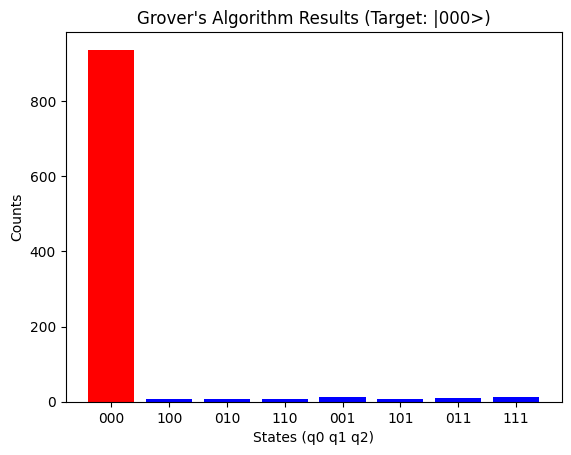

In [ ]:
# Install cirq in Colab
!pip install cirq

import cirq
import numpy as np
import matplotlib.pyplot as plt


def int_to_bitstring_le(x: int, n: int) -> str:
    """Little-endian bitstring for Cirq histogram integers.
       Returns string with qubit0 as first char: q0 q1 q2 ...
    """
    return ''.join(str((x >> i) & 1) for i in range(n))


def grover_3_qubit(target_binary: str):
    assert len(target_binary) == 3 and set(target_binary) <= {"0", "1"}, "target must be 3 bits (0/1)"

    qubits = list(cirq.LineQubit.range(3))  # q0, q1, q2
    circuit = cirq.Circuit()

    # Initialize to uniform superposition
    circuit.append(cirq.H.on_each(*qubits))

    # Number of Grover iterations (for N=8 -> 2 iterations)
    N = 2 ** 3
    iterations = int(np.floor(np.pi / 4 * np.sqrt(N)))

    for _ in range(iterations):
        apply_oracle(circuit, qubits, target_binary)
        apply_diffusion(circuit, qubits)

    # Measure
    circuit.append(cirq.measure(*qubits, key='result'))
    return circuit, qubits


def apply_oracle(circuit: cirq.Circuit, qubits, target_binary: str):
    for i, bit in enumerate(target_binary):
        if bit == '0':
            circuit.append(cirq.X(qubits[i]))

    # CCZ: Z on q2 controlled by q0 and q1
    ccz = cirq.Z(qubits[2]).controlled_by(qubits[0], qubits[1])
    circuit.append(ccz)

    for i, bit in enumerate(target_binary):
        if bit == '0':
            circuit.append(cirq.X(qubits[i]))


def apply_diffusion(circuit: cirq.Circuit, qubits):
    circuit.append(cirq.H.on_each(*qubits))
    circuit.append(cirq.X.on_each(*qubits))

    ccz = cirq.Z(qubits[2]).controlled_by(qubits[0], qubits[1])
    circuit.append(ccz)

    circuit.append(cirq.X.on_each(*qubits))
    circuit.append(cirq.H.on_each(*qubits))


def analyze_results(counts, target: str):
    n = 3
    counts_by_bits = {}
    for state_int, cnt in counts.items():
        bs = int_to_bitstring_le(state_int, n)
        counts_by_bits[bs] = cnt

    total = sum(counts_by_bits.values())
    success = counts_by_bits.get(target, 0)
    success_rate = 100.0 * success / total if total else 0.0

    print(f"\nMeasurement results for target |{target}>:")
    all_states = [int_to_bitstring_le(i, n) for i in range(2**n)]
    for bs in all_states:
        cnt = counts_by_bits.get(bs, 0)
        pct = 100.0 * cnt / total if total else 0.0
        marker = "<-- Target" if bs == target else ""
        print(f"State |{bs}>: {cnt} times ({pct:.2f}%) {marker}")

    print(f"\nSuccess rate: {success_rate:.2f}% (expected ≈90–95% after 2 iterations)")

    # Plot histogram
    values = [counts_by_bits.get(bs, 0) for bs in all_states]
    colors = ['red' if bs == target else 'blue' for bs in all_states]
    plt.bar(all_states, values, color=colors)
    plt.title(f"Grover's Algorithm Results (Target: |{target}>)")
    plt.xlabel("States (q0 q1 q2)")
    plt.ylabel("Counts")
    plt.show()


# ---- Run it ----
target = "000"
circuit, qubits = grover_3_qubit(target)

print("Circuit diagram:")
print(circuit)

simulator = cirq.Simulator()
result = simulator.run(circuit, repetitions=1000)

counts = result.histogram(key='result')
analyze_results(counts, target)


In [ ]:
Result
The successful implementation of Grover's algorithm for a 3-qubit database validates the
theoretical foundations of quantum search algorithms and provides a practical demonstration of
quantum computing potential for solving problems more efficiently than classical computers.